## Importing data manipulation

In [66]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor
plt.rcParams["figure.figsize"] = (15,10)

files = ["Delhi",
         "East_20", "East_100", "East_500",
         "North_20", "North_100", "North_500",
         "South_20", "South_100", "South_500",
         "West_20", "West_100", "West_500"]
#List containing the data for different cities
data = []

for i in range(len(files)):
    data_ = pd.read_csv("data/" + files[i] + ".csv")
    data_ = data_.drop(["Snow (cm)"], axis = 1)

    if i != 0:
        date_ = data_.pop("date")
    else:
        rs = np.random.RandomState(0)
        corr = data_.corr()
    data.append(data_)

In [67]:
regression_attr = "Max Temp (c)"
class PreProcessor:
#days denote size of the window
    def __init__(self, data, days, attr):
        # X and Y data
        self.X = np.zeros((data[0].shape[0] - days, ((data[0].shape[1] - 1)*len(data))*days))
        self.Y = np.zeros((self.X.shape[0], 1))

        #Concatination of cities data;
        data_cities = data[0]
        for i_ in range(1, len(data)):
            data_cities = pd.concat([data_cities, data[i_]], axis = 1)

        data_cities = data_cities.to_numpy()
        date_ = data[0]["date"]
        date = [[], [], []]

        #Data filing
        for i_ in range(0, self.X.shape[0]):
            for offset in range(0, days):
                index = (offset * (data_cities.shape[1] - 1))
                self.X[i_, index: index + data_cities.shape[1] - 1] = data_cities[i_ + offset, 1:]
            self.Y[i_, 0] = data[0][attr][i_+ days]

            day = int(date_[i_][ : date_[i_].index("-")])
            month = int(date_[i_][date_[i_].index("-") + 1 : date_[i_].rindex("-")])
            year = int(date_[i_][date_[i_].rindex("-") + 1 : ])
            date[0].append(day); date[1].append(month); date[2].append(year)

        self.X = np.append(self.X, np.array(date).T, axis = 1)
        self.standardize_data()

    #Standardizing the data
    def standardize_data(self):
        mean = np.mean(self.X, axis = 0)
        std = np.std(self.X, axis = 0)
        std[std == 0] = 1
        self.X = self.X - mean
        self.X = self.X / std

    #Splitting the data
    #def split(self):

def coeff_printer(file_order, given_model, data, days):
    index = 0

    print("day:", given_model.coef_[index])
    index += 1
    print("month:", given_model.coef_[index])
    index += 1
    print("year:", given_model.coef_[index])
    index += 1

    for day in range(days, 0, -1):
        for file in file_order:
            for (attr, val) in data[0].iteritems():
                if attr != "date":
                    str_coef = f"{round(given_model.coef_[index], 4)}"
                    print(f"Before: {str(day):4s} | file: {file:10s} | attr: {attr:40s}",
                          f":{str_coef:>10s}")
                    index += 1

In [68]:
obj = PreProcessor(data, 3, regression_attr)
obj.X[:, -2]

array([-1.58669398, -1.58669398, -1.58669398, ...,  0.75037508,
        0.75037508,  0.75037508])

## Importing Sklearn

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV


## Linear Regression

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


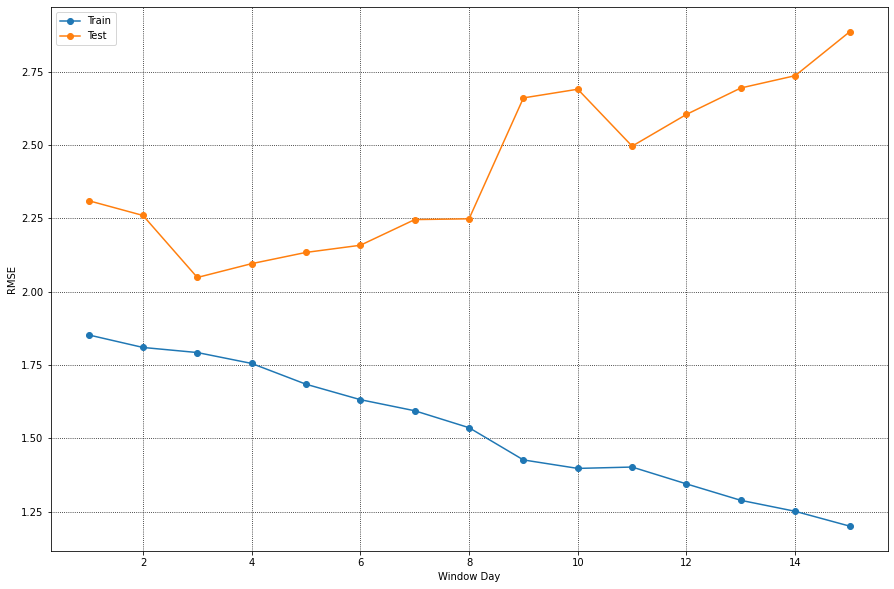

In [70]:
train_rmse_LR = []
test_rmse_LR = []
days = []
models_LR = []
coef = []
for i in range(1,16):
    obj = PreProcessor(data, i, regression_attr)
    x_train, x_test, y_train, y_test = train_test_split(obj.X, obj.Y, test_size=0.2, random_state=1)
    model = LinearRegression().fit(x_train, y_train)
    y_pred_test = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    models_LR.append(model)
    print(i)
    coef.append(model.coef_)
    days.append(i)
    test_rmse_LR.append(mean_squared_error(y_test, y_pred_test)**(1/2))
    train_rmse_LR.append(mean_squared_error(y_train, y_pred_train)**(1/2))


plt.plot(days, train_rmse_LR, "-o",label = "Train")
plt.plot(days, test_rmse_LR, "-o", label = "Test")
plt.ylabel("RMSE")
plt.xlabel("Window Day")
plt.legend()
plt.rc('grid', linestyle=":", color='black')
plt.grid()
plt.show()

## Lasso

1
2
3
4
5
6
7
8
9
10


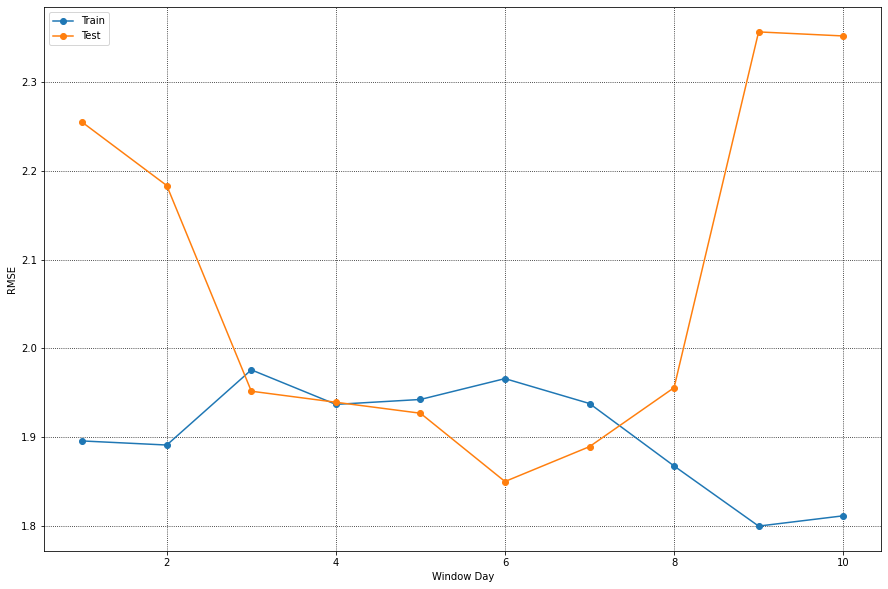

In [71]:
from sklearn.exceptions import ConvergenceWarning
train_rmse_LA = []
test_rmse_LA = []
days = []
models_LA = []
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    for i in range(1,11):
        import warnings
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        obj = PreProcessor(data, i, regression_attr)
        x_train, x_test, y_train, y_test = train_test_split(obj.X, obj.Y, test_size=0.2, random_state=1)
        model = LassoCV(cv=5, alphas=np.logspace(-5, 5, 100)).fit(x_train, np.ravel(y_train))
        y_pred_test = model.predict(x_test)
        y_pred_train = model.predict(x_train)
        models_LA.append(model)
        print(i)
        days.append(i)
        test_rmse_LA.append(mean_squared_error(y_test, y_pred_test)**(1/2))
        train_rmse_LA.append(mean_squared_error(y_train, y_pred_train)**(1/2))


plt.plot(days, train_rmse_LA, "-o",label = "Train")
plt.plot(days, test_rmse_LA, "-o", label = "Test")
plt.ylabel("RMSE")
plt.xlabel("Window Day")
plt.legend()
plt.rc('grid', linestyle=":", color='black')
plt.grid()
plt.show()


## Ridge

1
2
3
4
5
6
7
8
9
10


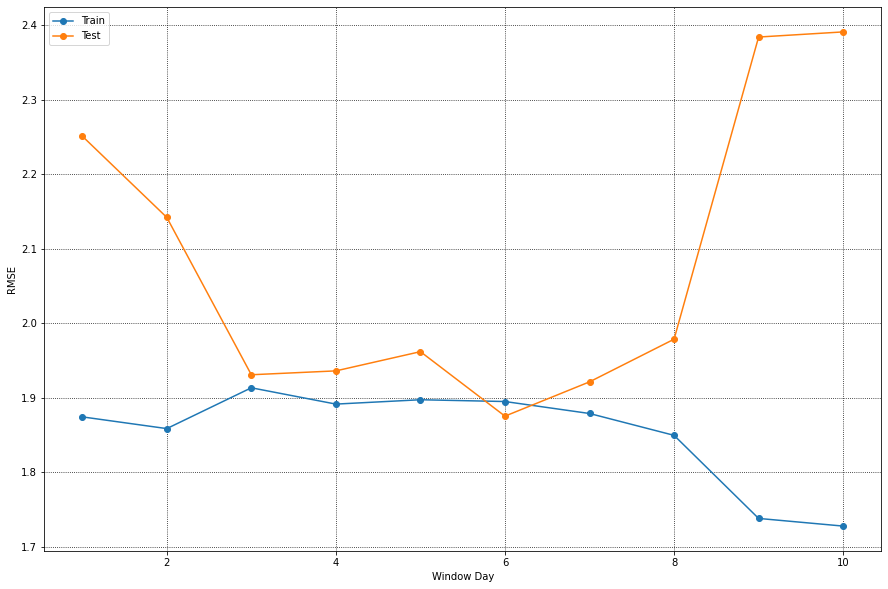

In [72]:
train_rmse_R = []
test_rmse_R = []
days = []
models_R = []
for i in range(1,11):
    obj = PreProcessor(data, i, regression_attr)
    x_train, x_test, y_train, y_test = train_test_split(obj.X, obj.Y, test_size=0.2, random_state=1)
    model = RidgeCV(cv=5, alphas=np.logspace(-5, 5, 100)).fit(x_train, np.ravel(y_train))
    y_pred_test = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    models_R.append(model)
    print(i)
    days.append(i)
    test_rmse_R.append(mean_squared_error(y_test, y_pred_test)**(1/2))
    train_rmse_R.append(mean_squared_error(y_train, y_pred_train)**(1/2))


plt.plot(days, train_rmse_R, "-o",label = "Train")
plt.plot(days, test_rmse_R, "-o", label = "Test")
plt.ylabel("RMSE")
plt.xlabel("Window Day")
plt.legend()
plt.grid()
plt.show()


## MLP

1
2
3
4
5
6
7
8
9


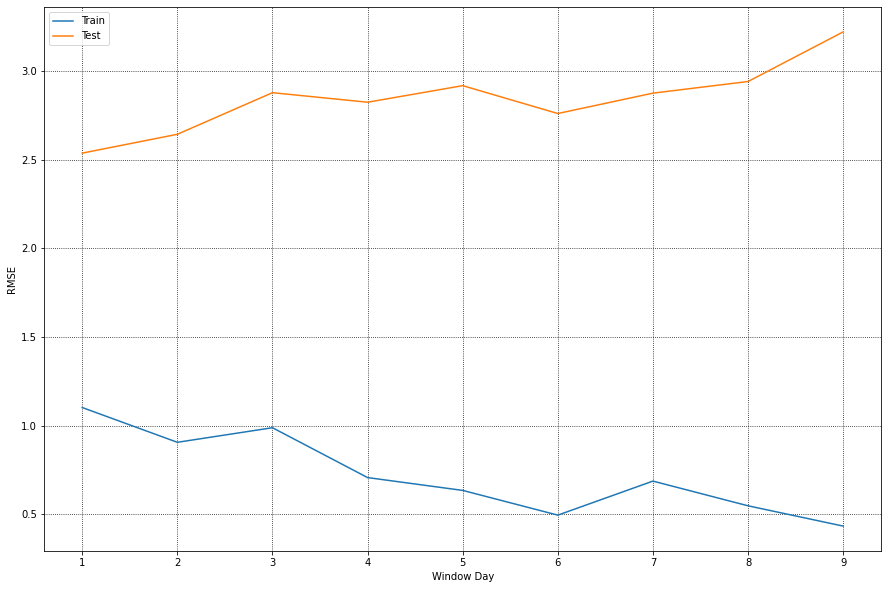

In [80]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

train_rmse_MLP = []
test_rmse_MLP = []
days = []
models_MLP = []
for i in range(1,10):
    obj = PreProcessor(data, i, regression_attr)
    x_train, x_test, y_train, y_test = train_test_split(obj.X, obj.Y, test_size=0.2, random_state=1)
    model = MLPRegressor(random_state=1, max_iter=500, alpha=0.1, hidden_layer_sizes=(128, 64, 32, 16)).fit(x_train, np.ravel(y_train))
    y_pred_test = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    models_MLP.append(model)
    print(i)
    days.append(i)
    test_rmse_MLP.append(mean_squared_error(y_test, y_pred_test)**(1/2))
    train_rmse_MLP.append(mean_squared_error(y_train, y_pred_train)**(1/2))

plt.plot(days, train_rmse_MLP, label = "Train")
plt.plot(days, test_rmse_MLP, label = "Test")
plt.ylabel("RMSE")
plt.xlabel("Window Day")
plt.legend()
plt.rc('grid', linestyle=":", color='black')
plt.grid()
plt.show()

In [81]:
# coeff_printer(files, models_LA[0], data, days=1)

In [82]:
#Grid Search on Lasso
# range_ = {"alpha":np.logspace(-10,10,500)}
# clif = Lasso()
# model = GridSearchCV(clif, range_, cv = 7)
# obj = PreProcessor(data, 3, regression_attr)
# x_train, x_test, y_train, y_test = train_test_split(obj.X, obj.Y, test_size=0.2, random_state=1)
# model.fit(obj.X, np.ravel(obj.Y), normalize = True)
# print(model.best_params_)
# best = Ridge(alpha = model.best_params_['alpha'])
# best.fit(obj.X, np.ravel(obj.Y))
# parameters = best.coef_
# parameters = np.append(parameters,best.intercept_)
# print(parameters)

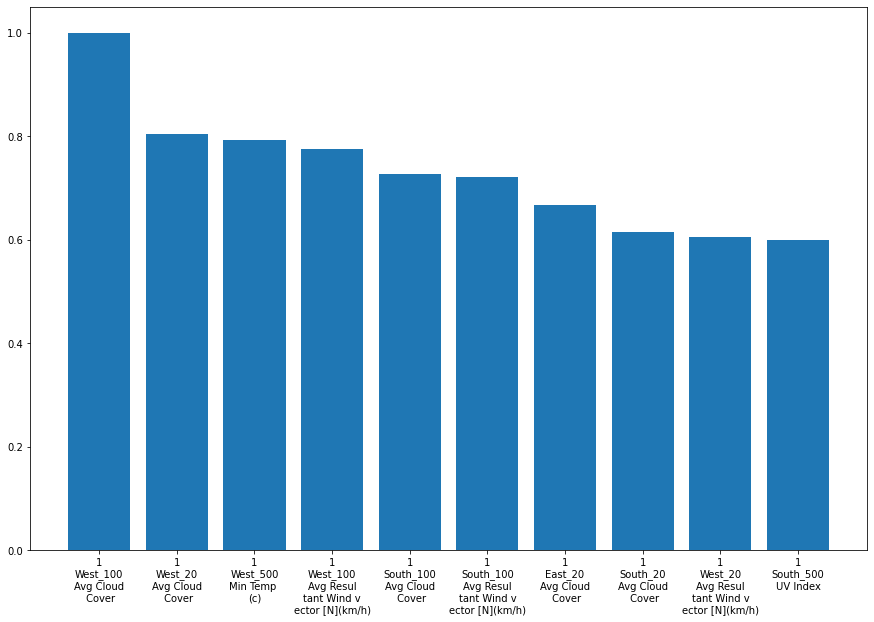

In [102]:
# Lowest
# print("LR Min:", min(*test_rmse_LR), "; On n=", (test_rmse_LR.index(min(*test_rmse_LR))+1))
# print("Lasso Min:", min(*test_rmse_LA), "; On n=", test_rmse_LA.index(min(*test_rmse_LA))+1)
# print("Ridge Min:", min(*test_rmse_R), "; On n=", test_rmse_R.index(min(*test_rmse_R))+1)
#
# print("\nLR 3:", test_rmse_LR[2])
# print("Lasso 3:", test_rmse_LA[2])
# print("Ridge 3:", test_rmse_R[2])
def coeff_namer(file_order, given_model, data, days, coeff_number):
    index = 0
    if index == coeff_number:
        # print("day:", given_model.coef_[index])
        return "day"
    index += 1
    if index == coeff_number:
        # print("month:", given_model.coef_[index])
        return "month"
    index += 1
    if index == coeff_number:
        # print("year:", given_model.coef_[index])
        return "year"
    index += 1

    for day in range(days, 0, -1):
        for file in file_order:
            for (attr, val) in data[0].iteritems():
                if attr != "date":
                    str_coef = f"{round(given_model.coef_[index], 4)}"
                    if index == coeff_number:
                        # print(f"Before: {str(day):4s} | file: {file:10s} | attr: {attr:40s}",
                        #   f":{str_coef:>10s}")
                        return f"{str(day)}\n{file}\n{attr[0: 9]}\n{attr[9:20]}\n{attr[20:]}"
                    index += 1
    return ""

zipped = list(zip(np.abs(models_R[2].coef_)/np.max(np.abs(models_R[2].coef_)), range(0, len(models_R[2].coef_))))
zs = sorted(zipped)
# print(zs)
labels = []
heights = []
# coeff_printer(files, models_R[0], data, 1)
for i in range(0, 10):
    # print(coeff_namer(files, models_R[2], data, 3, (zs[-1-i])[1]))
    labels.append(coeff_namer(files, models_R[2], data, 3, (zs[-1-i])[1]))
    heights.append((zs[-1-i])[0])
plt.bar(labels, heights)
plt.show()

## Decision Tree

1
2
3
4
5
6
7
8
9


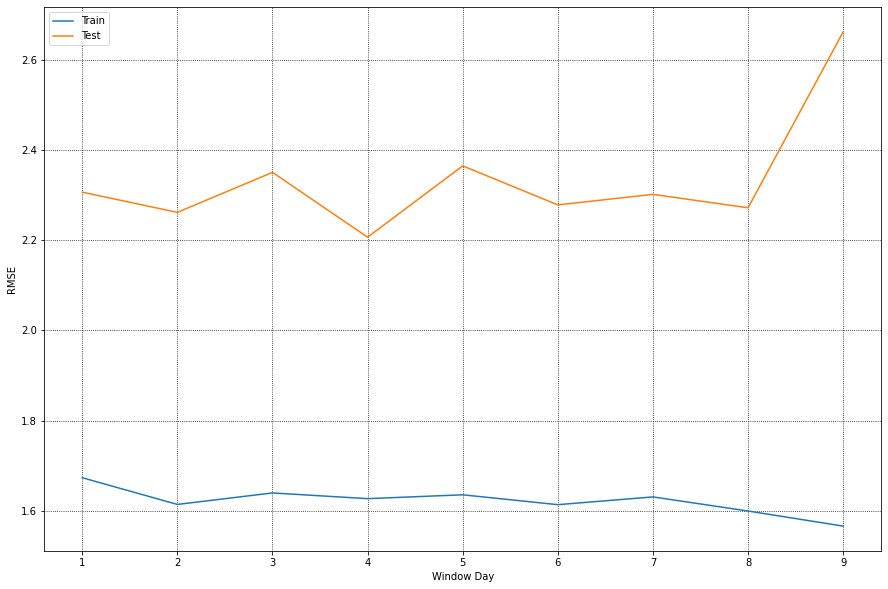

In [91]:
from sklearn.tree import DecisionTreeRegressor

train_rmse_DT = []
test_rmse_DT = []
days = []
models_DT = []
for i in range(1,10):
    obj = PreProcessor(data, i, regression_attr)
    x_train, x_test, y_train, y_test = train_test_split(obj.X, obj.Y, test_size=0.2, random_state=1)
    model = DecisionTreeRegressor(random_state=1, max_depth=7).fit(x_train, np.ravel(y_train))
    y_pred_test = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    models_DT.append(model)
    print(i)
    days.append(i)
    test_rmse_DT.append(mean_squared_error(y_test, y_pred_test)**(1/2))
    train_rmse_DT.append(mean_squared_error(y_train, y_pred_train)**(1/2))

plt.plot(days, train_rmse_DT, label = "Train")
plt.plot(days, test_rmse_DT, label = "Test")
plt.ylabel("RMSE")
plt.xlabel("Window Day")
plt.rc('grid', linestyle=":", color='black')
plt.grid()
plt.legend()
plt.show()

## Ada Boost

1
2
3
4
5
6
7
8
9


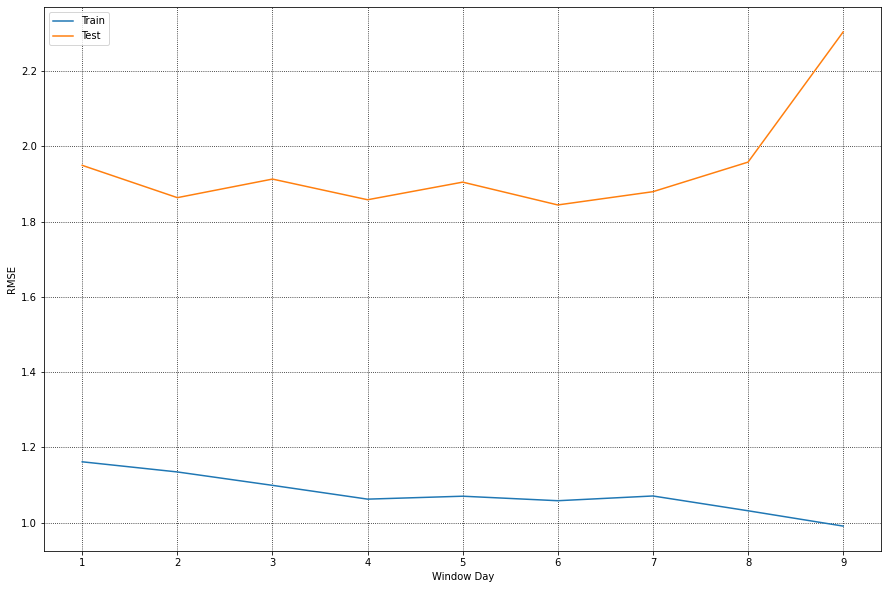

In [97]:
from sklearn.ensemble import AdaBoostRegressor

train_rmse_ADT = []
test_rmse_ADT = []
days = []
models_ADT = []
for i in range(1,10):
    obj = PreProcessor(data, i, regression_attr)
    x_train, x_test, y_train, y_test = train_test_split(obj.X, obj.Y, test_size=0.2, random_state=1)
    model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=7), random_state=1, n_estimators=250).fit(x_train, np.ravel(y_train))
    y_pred_test = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    models_ADT.append(model)
    print(i)
    days.append(i)
    test_rmse_ADT.append(mean_squared_error(y_test, y_pred_test)**(1/2))
    train_rmse_ADT.append(mean_squared_error(y_train, y_pred_train)**(1/2))

plt.plot(days, train_rmse_ADT, label = "Train")
plt.plot(days, test_rmse_ADT, label = "Test")
plt.ylabel("RMSE")
plt.xlabel("Window Day")
plt.rc('grid', linestyle=":", color='black')
plt.grid()
plt.legend()
plt.show()

# Accuracies

In [98]:
def get_lowest_index(array):
    val = min(*array)
    return array.index(val)

best_rmse_lr = get_lowest_index(test_rmse_LR)
best_rmse_la = get_lowest_index(test_rmse_LA)
best_rmse_r = get_lowest_index(test_rmse_R)
best_rmse_mlp = get_lowest_index(test_rmse_MLP)
best_rmse_dt = get_lowest_index(test_rmse_DT)
best_rmse_adt = get_lowest_index(test_rmse_ADT)

print("LR Best days:", best_rmse_lr+1, "Val:", test_rmse_LR[best_rmse_lr])
print("LA Best days:", best_rmse_la+1, "Val:", test_rmse_LA[best_rmse_la])
print("R Best days:", best_rmse_r+1, "Val:", test_rmse_R[best_rmse_r])
print("MLP Best days:", best_rmse_mlp+1, "Val:", test_rmse_MLP[best_rmse_mlp])
print("DT Best days:", best_rmse_dt+1, "Val:", test_rmse_DT[best_rmse_dt])
print("ADT Best days:", best_rmse_adt+1, "Val:", test_rmse_ADT[best_rmse_adt])

print("\nLR default Val:", test_rmse_LR[2])
print("LA default Val:", test_rmse_LA[2])
print("R default Val:", test_rmse_R[2])
print("MLP default Val:", test_rmse_MLP[2])
print("DT default Val:", test_rmse_DT[2])
print("ADT default Val:", test_rmse_ADT[2])



LR Best days: 3 Val: 2.0482616248747307
LA Best days: 6 Val: 1.849873531697932
R Best days: 6 Val: 1.8755503823297586
MLP Best days: 1 Val: 2.5362748850123347
DT Best days: 4 Val: 2.206706339821558
ADT Best days: 6 Val: 1.8442121966753882

LR default Val: 2.0482616248747307
LA default Val: 1.9517015817473433
R default Val: 1.9310783046996942
MLP default Val: 2.876843870125432
DT default Val: 2.3504100366394995
ADT default Val: 1.912956773333538
